<a href="https://colab.research.google.com/github/GailB-ca/digital-display-reader/blob/main/Digital_Reader_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,622 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [7]:
!pip install flask
!pip install flask-ngrok
!pip install flask-restful
!pip install deskew

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7c83283c0404.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [23/Mar/2021 01:13:46] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [23/Mar/2021 01:13:46] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/Mar/2021 01:13:53] "GET /read_digits HTTP/1.1" 200 -


Its a post
Minimum bounding area is:  42674.688
Adding to the array: width 276
Adding to the array: height 493
Adding to the array: width 212
Adding to the array: height 493
Adding to the array: width 282
Adding to the array: height 497
Adding to the array: width 303
Adding to the array: height 506
The images list type is <class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


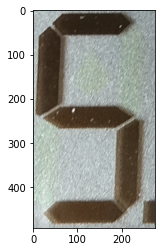

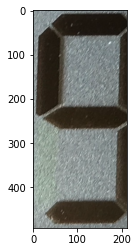

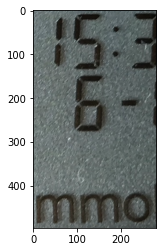

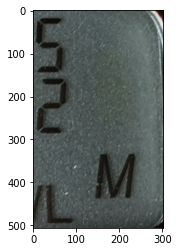

127.0.0.1 - - [23/Mar/2021 01:14:14] "POST /read_digits HTTP/1.1" 200 -


[5 5 2 1]


In [16]:
# import Flask and jsonify
from flask import Flask, render_template, jsonify, request
from flask_ngrok import run_with_ngrok
# import Resource, Api and reqparser
from flask_restful import Resource, Api, reqparse
import numpy as np
import lhl_model_utils as lhl_model
import lhl_build_dataframe as lhl_df
import lhl_image_transform as lhl_img
import importlib
importlib.reload(lhl_model)
importlib.reload(lhl_df)
import pandas as pd
import cv2

app = Flask(__name__, template_folder='/content/drive/MyDrive/Colab Notebooks/templates')

api = Api(app)

app.config['MAX_CONTENT_LENGTH'] = 6000 * 6000
app.config['UPLOAD_EXTENSIONS'] = ['.jpg', '.png', '.gif']

# Load the classifier model 
classifier_model = lhl_model.load_model('/content/drive/MyDrive/Colab Notebooks/digit_classifier_model1')
    
# Create a /read_digits resource for the API
class ReadDigits(Resource):
    def post(self):
        
        file = request.files['file']
        npimg = np.fromfile(file, np.uint8)
        file = cv2.imdecode(npimg, cv2.IMREAD_COLOR)

        
        
        #json_data = request.get_json()
        #df = pd.DataFrame(json_data.values(), index=json_data.keys()).transpose()

        #res = lhl.predict_digits(images_list, classifier_model)
        
        # we cannot send numpy array as a result
        #return res.tolist() 
    
    def get(self):
        return render_template('digit_classifier_index.html')

# assign endpoint to the resource
api.add_resource(ReadDigits, '/read_digits_api')        

@app.route('/read_digits', methods=['GET', 'POST'])
def read_digits():
    if request.method == 'GET':
        return render_template('digit_classifier_index.html')

    if request.method == 'POST':
        print('Its a post')
        
        file = request.files['file']
        npimg = np.fromfile(file, np.uint8)
        img_arr = cv2.imdecode(npimg, cv2.IMREAD_COLOR)

        # Switch the image to B&W
        pr_image = lhl_img.img_process(img_arr
                          , threshold_block_size=91
                          , flatten_2=False)
        # Do the bounding
        boxes = lhl_img.compute_bounding(pr_image,
                                         r'/usr/bin/tesseract')

        # Get the list of images
        images_list = np.array(lhl_img.extract_bounded_image_arr(img_arr, boxes))

        print("The images list type is", type(images_list))
        for img in images_list:
          lhl_img.plot_image(img)
        
        #images_list = np.expand_dims(img_arr, axis=0)
        images_res_list = lhl_df.process_resize_with_distortion(images_list)
        res = lhl_model.predict_digits(images_res_list, classifier_model)
        
        print(res)
        # we cannot send numpy array as a result
        #return res.tolist() 
        
        return render_template('digit_classifier_response.html', 
                               result_list=list(res)
                               )
        

run_with_ngrok(app)
app.run()